# TME sur la classification de lettres manuscrites
## Format des données
Nous travaillerons sur des lettres manuscrites.
Les données sont fournies au format pickle (le standard de sérialisation python, particulièrement convivial). Pour les charger : 

In [204]:
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt

with open('lettres.pkl', 'rb') as f:
    data = pkl.load(f, encoding='latin1') 
X = np.array(data.get('letters'), dtype=object) # récupération des données sur les lettres
Y = np.array(data.get('labels')) # récupération des étiquettes associées

Les données sont dans un format original: une lettre est en fait une série d'angles (exprimés en degrés). Un exemple: 

In [205]:
X[0]

array([ 36.214493, 347.719116, 322.088898, 312.230957, 314.851013,
       315.487213, 313.556702, 326.534973, 141.288971, 167.606689,
       199.321594, 217.911087, 226.443298, 235.002472, 252.354492,
       270.045654, 291.665161, 350.934723,  17.892815,  20.281025,
        28.207161,  43.883423,  53.459026])

Lors de l'acquisition, un stylo intelligent a pris des mesures régulièrement dans le temps: chaque période correspond à un segment de droite et le stylo a calculé l'angle entre deux segments consécutifs... C'est l'information qui vous est fournie.

Pour afficher une lettre, il faut reconstruire la trajectoire enregistrée... C'est ce que fait la méthode ci-dessous: 

In [206]:
# affichage d'une lettre
def tracerLettre(let):
    a = -let*np.pi/180; # conversion en rad
    coord = np.array([[0, 0]]); # point initial
    for i in range(len(a)):
        x = np.array([[1, 0]])
        rot = np.array([[np.cos(a[i]), -np.sin(a[i])],[ np.sin(a[i]),np.cos(a[i])]])
        xr = x.dot(rot) # application de la rotation
        coord = np.vstack((coord,xr+coord[-1,:]))
    plt.figure()
    plt.plot(coord[:,0],coord[:,1])
    #plt.savefig("exlettre.png")
    return

[ 36.214493 347.719116 322.088898 312.230957 314.851013 315.487213
 313.556702 326.534973 141.288971 167.606689 199.321594 217.911087
 226.443298 235.002472 252.354492 270.045654 291.665161 350.934723
  17.892815  20.281025  28.207161  43.883423  53.459026]
a


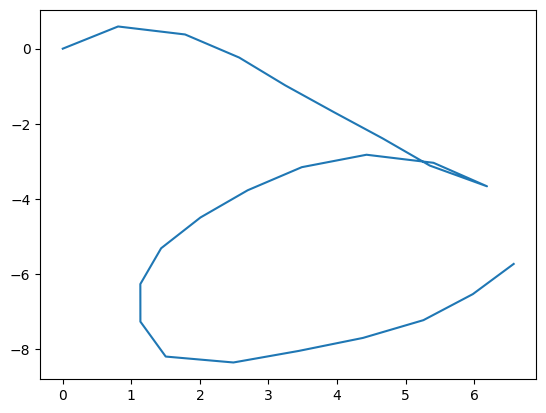

In [207]:
# il s'agit d'un 'a'
n = 0
print(X[n])
tracerLettre(X[n])
print(Y[n]) # vérification de l'étiquette

## A. Apprentissage d'un modèle CM (max de vraisemblance)
### A1. Discrétisation

**1 état = 1 angle**

Il est nécessaire de regrouper les angles en un nombre fini d'états (par exemple 20)
- définir un `intervalle = 360 / n_etats` (18° si on choisit 20 états)
- discrétiser tous les signaux à l'aide de la formule `np.floor(x / intervalle)`
    - si n_etats = 20 alors [0, 18[ => 0, [18, 36[ => 1, etc...

Donner le code de la méthode `discretise(x, d)` qui prend la base des signaux et retourne une base de signaux discrétisés.

In [208]:
def discretise(X, d):
    """
    Fonction qui discrétise la répartition X en d intervalles
    Renvoie un array de même taille que X avec l'intervalle associée pour chaque valeur
    Chaque Intervalle correspond donc à une portion d'angle d'un disque de 360°
    """
    intervalle = 360 / d
    return np.array([np.floor(x / intervalle) for x in X], dtype=object)

print(discretise(X[0],3))

[0.0 2.0 2.0 2.0 2.0 2.0 2.0 2.0 1.0 1.0 1.0 1.0 1.0 1.0 2.0 2.0 2.0 2.0
 0.0 0.0 0.0 0.0 0.0]


In [209]:
print(X[3])
print(discretise(X,3)[3])

[309.471771 298.097443 287.645508 280.141266 287.645508  60.959606
 116.727104 156.056641 183.613403 210.800156 238.284058 253.906677
 270.045654 270.045654 277.152832 332.303772  24.182476  35.657139
  36.214493  41.429058]
[2. 2. 2. 2. 2. 0. 0. 1. 1. 1. 1. 2. 2. 2. 2. 2. 0. 0. 0. 0.]


**VALIDATION :** code du premier signal avec une discrétisation sur 3 états:
```python
array([ 0.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  1.,  1.,  1.,  1., 1., 1., 2., 2.,  2.,
       2.,  0.,  0.,  0.,  0.,  0.])
```

### A2. Regrouper les indices des signaux par classe (pour faciliter l'apprentissage)

In [210]:
def groupByLabel(y):
    """
    Fonction qui renvoie une matrice contenant des array des indices de chaque classe associée
    La première classe étant associée à la lettre 'a', le premier array de la matrice correspondra à tous
    les indices des images de cette lettre dans la liste X
    """
    index = []
    for i in np.unique(y): # pour toutes les classes
        ind, = np.where(y == i)
        index.append(ind)
    return index

print(Y[0])
print(Y.shape)
for i in range(len(groupByLabel(Y))):
    print(groupByLabel(Y)[i], np.unique(Y)[i])

a
(268,)
[ 0  1  2  3  4  5  6  7  8  9 10] a
[11 12 13 14 15 16 17 18 19 20 21] b
[22 23 24 25 26 27 28 29 30 31 32] c
[33 34 35 36 37 38 39 40 41 42 43] d
[44 45 46 47 48 49 50 51 52 53 54] e
[55 56 57 58 59 60 61 62 63 64 65] f
[66 67 68 69 70 71 72 73 74 75 76] g
[77 78 79 80 81 82 83 84 85 86 87] h
[88 89 90 91 92 93 94 95 96 97] i
[ 98  99 100 101 102 103 104 105 106 107] j
[108 109 110 111 112 113 114 115 116 117] k
[118 119 120 121 122 123 124 125 126 127] l
[128 129 130 131 132 133 134 135 136 137] m
[138 139 140 141 142 143 144 145 146 147] n
[148 149 150 151 152 153 154 155 156 157] o
[158 159 160 161 162 163 164 165 166 167] p
[168 169 170 171 172 173 174 175 176 177] q
[178 179 180 181 182 183 184 185 186 187] r
[188 189 190 191 192 193 194 195 196 197] s
[198 199 200 201 202 203 204 205 206 207] t
[208 209 210 211 212 213 214 215 216 217] u
[218 219 220 221 222 223 224 225 226 227] v
[228 229 230 231 232 233 234 235 236 237] w
[238 239 240 241 242 243 244 245 246 247] x
[

Cette méthode produit simplement une structure type:
```python
[array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 array([11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]),
 array([22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]),
 array([33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43]),
 array([44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54]),
 array([55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65]),
 ...
```
Chaque ligne regroupe les indices de signaux correspondant à une classe. Il y a donc 11 exemples de 'a'.

### A3. Apprendre les modèles CM

Soit {$X_C$} la base de signaux discrétisés correspondant à une classe {$C$} et {$d$} le nombre d'états. Donner le code de la fonction `learnMarkovModel(Xc, d)` qui retourne un tuple contenant Pi et A.

Rappel:
- Initialisation de 
```python
 A = np.zeros((d, d))
 Pi = np.zeros(d)```
- Parcours de tous les signaux et incréments de A et Pi
- Normalisation (un peu réfléchie pour éviter les divisions par 0)
```python
A = A / np.maximum(A.sum(1).reshape(d, 1), 1) # normalisation
Pi = Pi / Pi.sum()```

**Note** : la solution proposée pour gérer le cas des lignes entièrement à 0 est naïve et n'est pas totalement satisfaisante. Comprendre pourquoi. On proposera une solution améliorée plus loin dans le TME. 

In [211]:
def learnMarkovModel(Xc, d):
    A = np.zeros((d,d))
    Pi = np.zeros(d)
    
    for x in Xc:
        Pi[int(x[0])] += 1
        for index in range(len(x)-1):
            # index = instant t
            # index+1 = instant t+1
            A[ int(x[index]), int(x[index+1]) ] += 1
    A = A / np.maximum(A.sum(1).reshape(d, 1), 1)
    Pi = Pi / Pi.sum()    
            
    return Pi, A
    
Xc = np.array([ discretise(X, 3)[a] for a in groupByLabel(Y)[0]], dtype=object)

Pi, A = learnMarkovModel(Xc, 3)

print('Pi=\n', Pi)
print()
print('A=\n', A)

# Pi la probabilité initiale de commencer dans un des états donnés, les états étant des angles
# A la matrice de transisiton d'un instant t à t+1


Pi=
 [0.36363636 0.         0.63636364]

A=
 [[0.84444444 0.06666667 0.08888889]
 [0.         0.83333333 0.16666667]
 [0.11382114 0.06504065 0.82113821]]


**Validation :** premier modèle avec une discrétisation sur 3 états :
```python
(array([ 0.36363636,  0.        ,  0.63636364]),
 array([[ 0.84444444,  0.06666667,  0.08888889],
       [ 0.        ,  0.83333333,  0.16666667],
       [ 0.11382114,  0.06504065,  0.82113821]]))
```

### A4. Stocker les modèles dans une liste

Pour un usage ultérieur plus facile, on utilise le code suivant :

In [212]:
d = 20                   # paramètre de discrétisation
Xd = discretise(X, d)    # application de la discrétisation
index = groupByLabel(Y)  # groupement des signaux par classe
models = []
for cl in range(len(np.unique(Y))): # parcours de toutes les classes et optimisation des modèles
    models.append(learnMarkovModel( Xd[ index[cl] ], d) )
    
print(len(models), len(models[0]), len(models[0][0]), models[0][1].shape)
# 26 champs correspondants à chaque classe=lettre
#contenant 2 objets : le vecteur Pi et la matrice de transition A

26 2 20 (20, 20)


index[cl] représente l'ensemble des indices de la classe cl
on peut appeler l'ensemble des vecteurs de ces indices dans Xd directement grâce à numpy

$ A = np.array([k*2 for k in range(10)]) $

$ print(A[ [0,5,9] ])$

Va print un array qui contient les Valeurs des indices 0,5 et 9 de A


In [213]:
A = np.array([k*2 for k in range(10)])
print(A)
print(A[ [0,5,9] ])

[ 0  2  4  6  8 10 12 14 16 18]
[ 0 10 18]


### A5. Distribution stationnaire

La distribution stationnaire $\mu$, pour un système ergodique, correspond à:

- la distribution des états observés dans l'ensemble des données
- la distribution obtenue après un grand nombre de passages dans $A$ à partir de n'importe quelle distribution ou état d'origine (une matrice de transition ergodique va nous permettre de converger)
- la solution de l'équation de stabilité: $\mu = \mu A$

Dans le cas de la lettre 'a' et d'une discrétisation en 3 états, calculer la distribution stationnaire par les deux premières méthodes et vérifier que vous obtenez des résultats similaires.

**Note 1:** pour la marche aléatoire, vous construirez une boucle sur 100 iérations (borne sup) et vous sortirez dès que la somme des écarts (en absolu) entre $\mu_t$ et $\mu_{t+1}$ est inférieure à $10^{-3}$. Vous vérifierez ensuite que le système converge quelque soit l'état de départ (3 appel àla fonction) ou avec une initialisation aléatoire.

**Note 2:** les deux approches, bien que reposant sur les mêmes données, vont donner des solutions différentes. En effet, il n'y a que peu d'observations et le premier calcul repose sur les états alors que le second repose sur les transitions. 
Afin de vérifier l'exactitude de votre code, vous pourrez revenir sur cette question en fin de sujet avec le protocole suivant:
1. utiliser la matrice de transition de 'a' pour générer une séquence de longeur 100000
1. faire les statistiques des états (à l'aide d'un ```Counter``` par exemple)
1. vérifier la convergence sur de longues séquences

In [214]:
from random import randint

nb_intervalles = 3
def iterations(nb_intervalles, classe_i, aleatoire=False):
    if not aleatoire:
        Xi = np.array([ discretise(X, nb_intervalles)[i] for i in groupByLabel(Y)[classe_i]], dtype=object)
    else:
        Xi = np.array([ [randint(0,nb_intervalles-1) for i in range(len(discretise(X, nb_intervalles)[i]))] for j in range(len(groupByLabel(Y)[classe_i]))], dtype=object)

    Pi, A = learnMarkovModel(Xi, nb_intervalles)

    mu = [0 for i in range(nb_intervalles)]
    for x in Xi:
        for p in range(nb_intervalles):
            mu[p] += np.bincount(list(x))[p]

    mu = np.array(mu) / sum(mu)
    print('mu =', mu)

    eps = 10**-3
    it_max = 100
    it = it_max
    while it > 0 and np.all(np.abs(mu-np.dot(A,mu)) > eps):
        mu = np.dot(A,mu)
        it -= 1
    print('mu =', mu, 'Après', it_max-it, 'Itérations' )
    

iterations(nb_intervalles, 0)
print()
iterations(nb_intervalles, 0, True)


mu = [0.22857143 0.26938776 0.50204082]
mu = [0.32513645 0.36360542 0.36703971] Après 6 Itérations

mu = [0.36363636 0.31818182 0.31818182]
mu = [0.33744222 0.33585859 0.33129371] Après 1 Itérations


In [215]:
d = 3
print(randint(0,d))

3


##  B. Test (affectation dans les classes sur critère MV)
### B1. (log)Probabilité d'une séquence dans un modèle

Donner le code de la méthode `probaSequence(s,Pi,A)` qui retourne la log-probabilité d'une séquence `s` dans le modèle {$\lambda=\{Pi,A\}$} 

In [216]:
from math import inf 
def probaSequence(s, Pi, A):
    # une séquence = 1 vecteur de taille 1xN
    produit = Pi[int(s[0])]
    
    for t in range(1,len(s)):
        #print(A[int(s[t]), int(s[t-1])], '\t', produit)
        produit *= A[int(s[t-1]), int(s[t])]
    if produit == 0:
        return -np.inf
    else:
        return np.log(produit)

    
d = 3
s = discretise(X, d)[0]
print('Séquence=',s)

print('\n')

indexes = groupByLabel(Y)
Xd = discretise(X, d)
probas = np.zeros((len(models)))

for lettre in range(len(models)):
    # Ensemble des vecteurs discrétisés associés à une classe=lettre
    Xi = Xd[indexes[lettre]]
    
    #construction de Pi et A associés à la classe i
    Pi, A = learnMarkovModel(Xi, d)
    
    #calcul de log de vraissemblance de la première séquence pour chaque classe
    probas[lettre] = probaSequence(s, Pi, A)
print(probas)


Séquence= [0. 2. 2. 2. 2. 2. 2. 2. 1. 1. 1. 1. 1. 1. 2. 2. 2. 2. 0. 0. 0. 0. 0.]


[-13.491086           -inf         -inf         -inf         -inf
         -inf         -inf         -inf         -inf         -inf
         -inf         -inf         -inf         -inf         -inf
         -inf         -inf         -inf         -inf         -inf
         -inf         -inf         -inf         -inf         -inf
 -12.48285678]


#### Par maximum de vraisemblance, le modèle indique que le premier signal appartient à la classe 26 soit la lettre 'z'

#### Or le premier signal est un 'a' ce qui signifie que le signal n'a pas été bien classé

#### En revanche, nous pouvons remarquer que les courbures(=angles) de ce premier signal se rapprochent plus de la lettre 'z' que de la lettre 'a', en effet on observe (à l'oeil nu) que les traits sont plus horizontaux que verticaux et arrondis, d'où le fait que l'algorithme a confondu ce 'a' pour un 'z'.

#### On peut remarquer aussi que pour un mot voire un texte entier, des erreurs sur quelques lettres ne sont pas forcément préjudiciables, car l'on peut utiliser ce même algorithme pour approximer un mot ou une phrase et ainsi corriger les erreurs sur les lettres.

ex : 'aèbre' pourra être approximé par 'zèbre'

**VALIDATION :** probabilité du premier signal dans les 26 modèles avec une discrétisation sur 3 états :
```python
array([-13.491086  ,         -inf,         -inf,         -inf,
               -inf,         -inf,         -inf,         -inf,
               -inf,         -inf,         -inf,         -inf,
               -inf,         -inf,         -inf,         -inf,
               -inf,         -inf,         -inf,         -inf,
               -inf,         -inf,         -inf,         -inf,
               -inf, -12.48285678])
```

- Ce signal est-il bien classé ?
- D'où viennent tous les `-inf` ? 

### B2. Application de la méthode précédente pour tous les signaux et tous les modèles de lettres

L'application se fait en une ligne de code si vous avez respecté les spécifications précédentes : 

In [217]:
index = groupByLabel(Y)  # groupement des signaux par classe


Xd_3 = discretise(X, 3)    # application de la discrétisation
models_3 = []
for cl in range(len(np.unique(Y))): # parcours de toutes les classes et optimisation des modèles
    models_3.append(learnMarkovModel( Xd_3[ index[cl] ], 3) )

    
# Bien différentier les variables de discrétisations de X ! 
Xd_20 = discretise(X, 20)    # application de la discrétisation
models_20 = []
for cl in range(len(np.unique(Y))): # parcours de toutes les classes et optimisation des modèles
    models_20.append(learnMarkovModel( Xd_20[ index[cl] ], 20) )

### B3. Evaluation des performances

Pour l'évaluation, nous proposons l'approche suivante: 

In [218]:
# calcul d'une version numérique des Y :
Ynum = np.zeros(Y.shape)
for num, char in enumerate(np.unique(Y)):
    Ynum[Y == char] = num

# Calcul de la classe la plus probable :
pred = proba_20.argmax(0) # max colonne par colonne

# Calcul d'un pourcentage de bonne classification :
np.where(pred != Ynum, 0.,1.).mean()

0.914179104477612

In [219]:
# calcul d'une version numérique des Y :
Ynum = np.zeros(Y.shape)
for num, char in enumerate(np.unique(Y)):
    Ynum[Y == char] = num

# Calcul de la classe la plus probable :
pred = proba_3.argmax(0) # max colonne par colonne

# Calcul d'un pourcentage de bonne classification :
np.where(pred != Ynum, 0.,1.).mean()

0.6902985074626866

**INDICE DE PERFORMANCE :** 91% de bonne classification avec 20 états, 69% avec 3 états

## C. Biais d'évaluation, notion de sur-apprentissage

Dans le protocole précédent, nous avons triché:
- les données servent d'abord à apprendre les modèles...
- puis nous nous servons des mêmes données pour tester les modèles ! Les performances sont forcément bonnes ! 

Afin de palier le problème, nous allons diviser en deux la base de données: une partie servira à l'apprentissage des modèles, l'autre à leur évaluation. Pour effectuer la division, nous fournissons le code suivant: 

In [220]:
# separation app/test, pc=ratio de points en apprentissage
def separeTrainTest(y, pc):
    indTrain = []
    indTest = []
    for i in np.unique(y): # pour toutes les classes
        ind, = np.where(y == i)
        n = len(ind)
        indTrain.append(ind[np.random.permutation(n)][:int(np.floor(pc * n))])
        indTest.append(np.setdiff1d(ind, indTrain[-1]))
    return indTrain, indTest

# exemple d'utilisation
itrain, itest = separeTrainTest(Y, 0.8)

dans `itrain`, nous obtenons les indices des signaux qui doivent servir en apprentissage pour chaque classe :

In [221]:
itrain

[array([10,  9,  0,  8,  6,  5,  3,  7], dtype=int64),
 array([12, 15, 19, 17, 16, 14, 18, 21], dtype=int64),
 array([29, 24, 25, 30, 28, 31, 27, 26], dtype=int64),
 array([39, 41, 38, 34, 36, 37, 42, 35], dtype=int64),
 array([53, 54, 52, 48, 45, 47, 44, 49], dtype=int64),
 array([65, 63, 59, 62, 55, 61, 60, 57], dtype=int64),
 array([75, 76, 68, 74, 73, 72, 70, 66], dtype=int64),
 array([80, 79, 84, 77, 81, 82, 83, 78], dtype=int64),
 array([95, 93, 89, 96, 88, 94, 90, 97], dtype=int64),
 array([100, 105, 107,  99, 102, 104,  98, 106], dtype=int64),
 array([111, 108, 112, 109, 110, 116, 117, 113], dtype=int64),
 array([118, 124, 122, 127, 126, 125, 119, 123], dtype=int64),
 array([132, 129, 131, 135, 137, 130, 133, 136], dtype=int64),
 array([138, 140, 139, 146, 143, 141, 144, 145], dtype=int64),
 array([155, 151, 152, 153, 156, 154, 148, 150], dtype=int64),
 array([158, 161, 165, 164, 167, 160, 166, 162], dtype=int64),
 array([169, 173, 171, 170, 176, 172, 177, 174], dtype=int64),
 

**Note :** pour faciliter l'évaluation des modèles, vous aurez besoin de re-fusionner tous les indices d'apprentissage et de test. Cela se fait avec les lignes de code suivantes : 

In [222]:
ia = []
for i in itrain:
    ia += i.tolist()    
it = []
for i in itest:
    it += i.tolist()

In [223]:
print(it)

[1, 2, 4, 11, 13, 20, 22, 23, 32, 33, 40, 43, 46, 50, 51, 56, 58, 64, 67, 69, 71, 85, 86, 87, 91, 92, 101, 103, 114, 115, 120, 121, 128, 134, 142, 147, 149, 157, 159, 163, 168, 175, 183, 184, 188, 196, 202, 205, 212, 214, 224, 226, 234, 236, 242, 246, 249, 257, 261, 267]


**Note 2 :** Du fait de la permutation aléatoire, les résultats vont bouger (un peu) à chaque execution du programme. 

### C1. Questions importantes
- Ré-utiliser les fonctions précédemment définies pour apprendre des modèles et les évaluer sans biais.
- Calculer et analyser les résultats obtenus en apprentissage et en test
- Etudier l'évolution des performances en fonction de la discrétisation

In [224]:
Xd_3 = discretise(X, 3)
models_app_3 = []
for cl in range(len(np.unique(Y))): # parcours de toutes les classes et optimisation des modèles
    models_app_3.append(learnMarkovModel( Xd_3[ itrain[cl] ], 3) )

    
proba_app_3 = np.array([[probaSequence(Xd_3[i], models_app_3[cl][0], models_app_3[cl][1]) for i in it]
                  for cl in range(len(np.unique(Y)))])
    
    
Xd_20 = discretise(X, 20)
models_app_20 = []
for cl in range(len(np.unique(Y))): # parcours de toutes les classes et optimisation des modèles
    models_app_20.append(learnMarkovModel( Xd_20[ itrain[cl] ], 20) )
    
proba_app_20 = np.array([[probaSequence(Xd_20[i], models_app_20[cl][0], models_app_20[cl][1]) for i in it]
                  for cl in range(len(np.unique(Y)))])


Text(0, 0.5, 'Pourcentage de bonne classification')

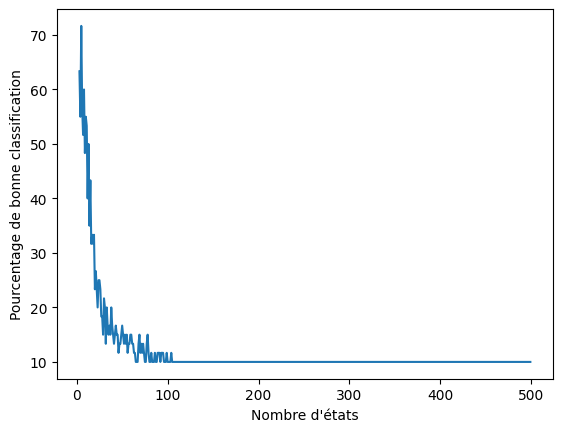

In [225]:
def performance(X, Y, nb_etats, array_train, indexes_test, ones=False):
    """
    Fonction qui calcule la proportion de bonne classification des données de test pour un certain nombre
    d'états donné en argument
    """
    Xd = discretise(X, nb_etats)
    models = []
    
    if not ones:
        for cl in range(len(np.unique(Y))):
            models.append( learnMarkovModel(Xd[array_train[cl]], nb_etats) )
    else:
        for cl in range(len(np.unique(Y))):
            models.append( learnMarkovModel_ones(Xd[array_train[cl]], nb_etats) )
    proba = np.array([[probaSequence(Xd[i], models[cl][0], models[cl][1]) for i in indexes_test] for cl in range(len(np.unique(Y)))])
    
    # Il y a exactement 60 signaux dans la liste de tests d'où la shape de probas :
    # 26 lignes correspondant aux 26 lettres(classes) et 60 colonnes=signaux
    
    # On doit changer la liste des hats pour pouvoir comparer des listes de même taille
    newY = Y[indexes_test]
    Ynum = np.zeros((len(indexes_test,)))
    for num, char in enumerate(np.unique(newY)):
        Ynum[newY == char] = num
    
    # Calcul de la classe la plus probable :
    pred = proba.argmax(0) # max colonne par colonne

    # Calcul d'un pourcentage de bonne classification :
    return np.where(pred != Ynum, 0.,1.).mean(), pred
    
res = []
pred_list = []
a,b = 3, 500
for etat in range(a,b):
    res_i, pred_i = performance(X, Y, etat, itrain, it)
    res.append(res_i)
    pred_list.append(pred_i)
#print(res)

plt.plot(range(a,b), [i*100 for i in res])
plt.xlabel('Nombre d\'états')
plt.ylabel('Pourcentage de bonne classification')



#### En séparant les données en deux listes distinctes de signaux : une liste d'apprentissage et une liste de test, on observe des valeurs différentes d'avant, plus précises et censées.

#### En effet on est censé connaître les classes des signaux pour l'apprentissage, mais le but d'un tel algorithme et de le tester sur des données qui n'ont pas servi à son apprentissage sinon il n'aurait aucun intérêt.

#### Pour une discrétisation en 20 états, la proportion de bonne classification chute de 20% passant de 90 à 70%

#### Pour une discrétisation en 3 états, la proportion de bonne classification reste identique égale à 69%

### C2. Lutter contre le sur-apprentissage
Cette base de données met en lumière le phénomène de sur-apprentissage : il y a peu de données et dès que le nombre d'états augmente, il y a trop peu d'exemple pour estimer correctement les matrices {$A, \pi$}. De nombreuses cases sont donc à 0, voire des lignes entières (d'où la sécurisation du code pour la normalisation des matrices stochastiques).

Ces 0 sont particulièrement discriminants: considérant la classe {$c$}, ils permettent d'éliminer de cette classe tout signal présentant cette caractéristique. Cette règle est trop forte compte tenu de la taille de la base d'apprentissage. Nous proposons une astuce pour palier cette faiblesse : lors du comptage, initialiser les matrices {$A, \pi$} avec ones au lieu de zeros . On fait semblant d'avoir observer une transition de chaque type avant même le début du comptage.

Comparer les performances en test.

In [226]:
def learnMarkovModel_ones(Xc, d):
    A = np.ones((d,d))
    Pi = np.ones(d)
    
    for x in Xc:
        Pi[int(x[0])] += 1
        for index in range(len(x)-1):
            # index = instant t
            # index+1 = instant t+1
            A[ int(x[index]), int(x[index+1]) ] += 1
    A = A / np.maximum(A.sum(1).reshape(d, 1), 1)
    Pi = Pi / Pi.sum()    
            
    return Pi, A


Text(0, 0.5, 'Pourcentage de bonne classification')

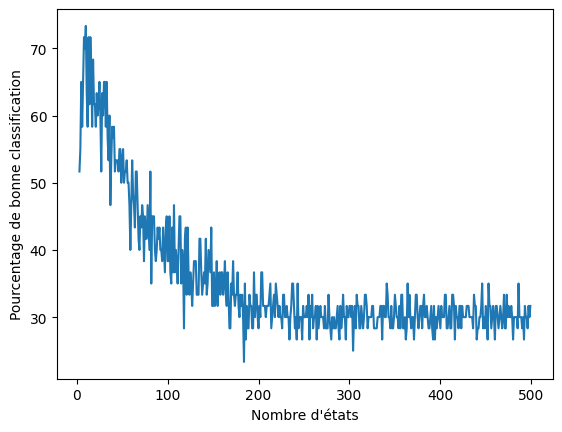

In [227]:
res_ones = []
pred_list_ones = []
a,b = 3,500
for etat in range(a,b):
    res_i, pred_i = performance(X, Y, etat, itrain, it, True)
    res_ones.append(res_i)
    pred_list_ones.append(pred_i)
#print(res)

plt.plot(range(a,b), [i*100 for i in res_ones])
plt.xlabel('Nombre d\'états')
plt.ylabel('Pourcentage de bonne classification')


#### Au même titre que précédement on observe une diminution progressive du pourcentage de bonne classification à mesure que le nombre d'états augmente.

#### Cependant, avec l'initialisation de Pi et A à 1 au lieu de 0, la décroissance observée est beaucoup moins rapide et semble converger vers un minimum (~33%) avec des oscillations au lieu de 0% pour le cas précédent.

## D. Evaluation qualitative

Nous nous demandons maintenant où se trouvent les erreurs que nous avons commises...

Calcul de la matrice de confusion: pour chaque échantillon de test, nous avons une prédiction (issue du modèle) et une vérité terrain (la vraie étiquette). En posant Nc le nombre de classes, la matrice de confusion est une matrice (Nc x Nc) où nous comptons le nombre d'échantillon de test dans chaque catégorie :

- Initialisation à 0 : 

In [228]:
conf = np.zeros((26,26))

- Pour chaque échantillon, incrément de la case (prediction, vérité)

In [229]:
# X = échantillons
# Y = tags de classe
# groupByLabel(Y) = indexes des classes dans X
# pred = classe prédite par l'algorithme

Y_hat=list(Ynum)                #Y_hat = Classes réelles
for i in range(len(Y_hat)):     #pred = Classes prédites
    Y_hat[i]=int(Y_hat[i])
Y_hat=np.array(Y_hat)

for i in range(268):
    conf[pred[i],Y_hat[i]]+=1

In [230]:
# X = échantillons
# Y = tags de classe
# groupByLabel(Y) = indexes des classes dans X
# pred = classe prédite par l'algorithme

#Les hats initiaux Y sont des str on doit donc les convertir en leur index associé, j'utilise un dictionnaire pour être plus clair et rapide
correspondance = {'a': 0, 'b': 1, 'c': 2, 'd': 3, 'e': 4, 'f': 5, 'g': 6, 'h': 7, 'i': 8, 'j': 9, 'k': 10, 'l': 11, 'm': 12, 'n': 13, 'o': 14, 'p': 15, 'q': 16, 'r': 17, 's': 18, 't': 19, 'u': 20, 'v': 21, 'w': 22, 'x': 23, 'y': 24, 'z': 25}
reverse = {0: 'a', 1: 'b', 2: 'c', 3: 'd', 4: 'e', 5: 'f', 6: 'g', 7: 'h', 8: 'i', 9: 'j', 10: 'k', 11: 'l', 12: 'm', 13: 'n', 14: 'o', 15: 'p', 16: 'q', 17: 'r', 18: 's', 19: 't', 20: 'u', 21: 'v', 22: 'w', 23: 'x', 24: 'y', 25: 'z'}
def matrice_confusion(Y_hats, Y_pred):
    conf = np.zeros((26,26))
    for signal in range(len(Y_hats)):
        conf[Y_pred[signal], correspondance[Y_hats[signal]]] += 1
    return conf

newY = Y[it]
print(newY, len(newY))
print([ reverse[i] for i in pred_list_ones[0]], len(pred_list_ones[0]))
t = np.array([ reverse[i] for i in pred_list_ones[0]])
print(np.unique(np.where(newY==t)[0]))

mat_conf = matrice_confusion(newY, pred_list_ones[0])
print(mat_conf.shape)

['a' 'a' 'a' 'b' 'b' 'b' 'c' 'c' 'c' 'd' 'd' 'd' 'e' 'e' 'e' 'f' 'f' 'f'
 'g' 'g' 'g' 'h' 'h' 'h' 'i' 'i' 'j' 'j' 'k' 'k' 'l' 'l' 'm' 'm' 'n' 'n'
 'o' 'o' 'p' 'p' 'q' 'q' 'r' 'r' 's' 's' 't' 't' 'u' 'u' 'v' 'v' 'w' 'w'
 'x' 'x' 'y' 'y' 'z' 'z'] 60
['p', 'p', 'z', 'b', 'b', 'b', 'o', 'o', 'o', 'd', 'd', 'p', 'e', 'e', 'd', 's', 'f', 'q', 'g', 'g', 'q', 'h', 'm', 'm', 'i', 'i', 'j', 'j', 'j', 'k', 'i', 'i', 'm', 'm', 'm', 'm', 'e', 'o', 'p', 'p', 'q', 'o', 'u', 'u', 's', 's', 'i', 'i', 'u', 'u', 'v', 'u', 'w', 'w', 'i', 'i', 'h', 'h', 'z', 'z'] 60
[ 3  4  5  9 10 12 13 16 18 19 21 24 25 26 27 29 32 33 37 38 39 40 44 45
 48 49 50 52 53 58 59]
(26, 26)


- Tracé de la matrice : 

Text(0, 0.5, 'Prédiction')

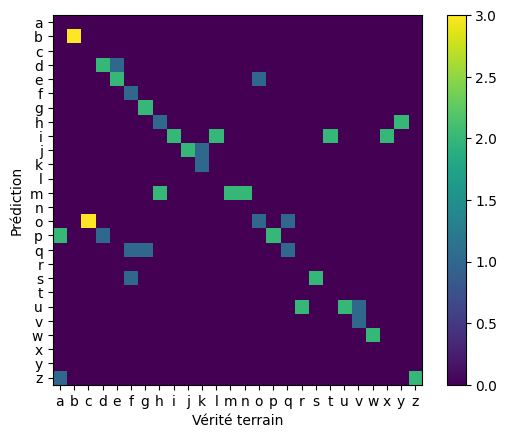

In [231]:
plt.figure()
plt.imshow(mat_conf, interpolation = 'nearest')
plt.colorbar()
plt.xticks(np.arange(26), np.unique(Y))
plt.yticks(np.arange(26), np.unique(Y))
plt.xlabel(u'Vérité terrain')
plt.ylabel(u'Prédiction')
#plt.savefig("mat_conf_lettres.png")

## E. Modèle génératif

Utiliser les modèles appris pour générer de nouvelles lettres manuscrites.

### E1. Tirage selon une loi de probabilité discrète

- faire la somme cumulée de la loi {$sc$}
- tirer un nombre aléatoire {$t$} entre 0 et 1
- trouver la première valeur de {$sc$} qui est supérieure à {$t$}
- retourner cet état 

**Note :** comme vu en cours, tout repose sur la somme cumulée (notée ici `sc$`, calculable en appelant `np.cumsum`. Sur un exemple: la loi `V = [0.2, 0.4, 0.3, 0.1]` a pour somme cumulée `V.cumsum() == [0.2,  0.6,  0.9,  1.0]`

### E2. Génération d'une séquence de longueur N

- tirer un état {$s_0$} selon Pi
- tant que la longueur n'est pas atteinte :
  - tirer un état {$s_{t+1}$} selon {$A[s_{t}]$} 

In [266]:
import random as rd 

def generate(Pi,A,n):
    lettre=[]
    i=0
    Pi_bis=Pi.cumsum()
    de=rd.random()
    while Pi_bis[i]<de:
        i+=1
    angle=i
    lettre.append(angle)
    N=1
    A_bis=A.copy()                              #copie de A car la méthode cumsum modifie directement la matrice A
    A_bis=np.cumsum(A_bis,axis=1)
    for N in range(n-1):
        i=0
        de=rd.random()
        while A_bis[angle][i]<de:
            i+=1
        angle=i
        lettre.append(angle)
    return lettre

### E3. Affichage du résultat

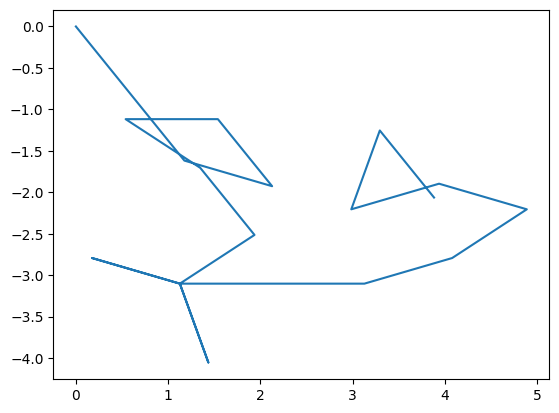

In [267]:
lettre=0
Xd = discretise(X,20)
models_ones = [ learnMarkovModel_ones(Xd[itrain[cl]], 20) for cl in range(len(np.unique(Y))) ]
newa = generate(models_ones[lettre][0], models_ones[lettre][1], 20)       # generation d'une séquence d'états
intervalle = 360. / 20                                 # pour passer des états => valeur d'angles
newa_continu = np.array([i * intervalle for i in newa]) # conv int => double
tracerLettre(newa_continu)